## ** Movie Recommendation System**

Objectif: when the user searches for a movie we will recommend the top 10 similar movies
* link for dataset: https://www.kaggle.com/shubhammehta21/movie-lens-small-latest-dataset


In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
movies = pd.read_csv("data/movies.csv")
ratings = pd.read_csv("data/ratings.csv")

### Data visualization

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Creating a new dataframe where each column represents each unique userId and each row represents each unique movieId.

In [5]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
final_dataset.fillna(0,inplace=True)#replace Nan values by 0
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


### Removing Noise from the data

* To qualify a movie, a minimum of 10 users should have voted a movie.
* To qualify a user, a minimum of 50 movies should have voted by the user.

In [10]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 50].index,:]

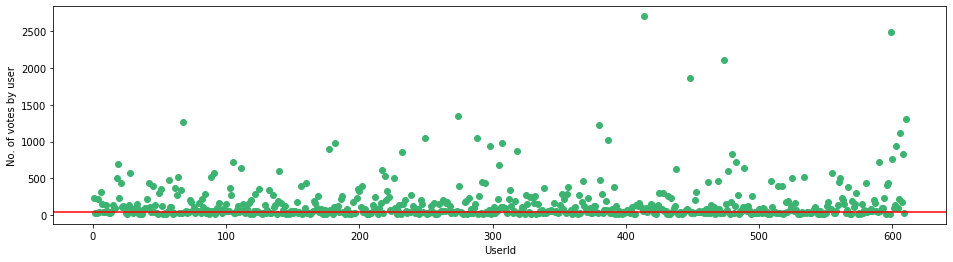

In [11]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

### Removing sparsity
To reduce the sparsity we use the csr_matrix function from the scipy library.

In [14]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

### making the model
We will be using  KNN algorithm to compute similarity with cosine distance metric which is very fast and more preferable than pearson coefficent.



In [15]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [16]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

### Testing

In [19]:
get_movie_recommendation('Jumanji')

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\pairw

,Title,Distance
1,Clueless (1995),0.723121
2,Grumpier Old Men (1995),0.712416
3,Heat (1995),0.697703
4,"American President, The (1995)",0.678838
5,Seven (a.k.a. Se7en) (1995),0.669740
6,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),0.645980
7,Babe (1995),0.616222
8,Toy Story (1995),0.589325
9,GoldenEye (1995),0.581831
10,Ace Ventura: When Nature Calls (1995),0.569218


In [18]:
get_movie_recommendation('Toy Story')

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\pairw

,Title,Distance
1,Sense and Sensibility (1995),0.703035
2,"American President, The (1995)",0.693358
3,Ace Ventura: When Nature Calls (1995),0.686158
4,Seven (a.k.a. Se7en) (1995),0.656776
5,"Usual Suspects, The (1995)",0.655689
6,Heat (1995),0.626275
7,GoldenEye (1995),0.614220
8,Babe (1995),0.604357
9,Jumanji (1995),0.589325
10,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),0.561749
